이 커널은 Kaggle [@Victor Ambonati](https://www.kaggle.com/victorambonati)님의 [Unsupervised Anomaly Detection](https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection)를 번역하고 부족한 내용을 보충한 내용입니다.

한국어로 의역하기 애매한 내용은 원문 그대로 사용하였음을 미리 밝힙니다.

This kernel translates Kaggle [Victor Ambonati](https://www.kaggle.com/victorambonati)'s [Unsupervised Anomaly Detection](https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection) .

Translator  
Kaggle: [@SANGMANNNN](https://www.kaggle.com/parksangmmin19930217)  
Github: [@SSANGMAN](https://github.com/SSANGMAN)

# Motivation : 
저는 최근에 이상 징후 발견에 대한 흥미로운 기사를 읽었습니다.: https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/.  
이상 징후 발견에 대해 더 잘 이해하고 싶어 이 기술들 중 몇 가지를 시도하고 싶었습니다. 먼저 단순 예제로 이상 징후 감지에 대해 흥미로운 데이터를 찾기 위해 Kaggle에 검색했습니다. NAB 데이터가 그 중 눈에 띄었고(이 데이터를 제공해주셔서 감사합니다.) 그 중 하나의 데이터셋을 선택하여 알고리즘을 구현했습니다. 

이 커널의 목표는 이러한 알고리즘을 구현하고 알고리즘의 특성을 이해하는 것입니다. 때로는 이 데이터셋에 대해 잘 몰라 이해하기 어려울 수 있습니다. 따라서 알고리즘이 무엇을 감지하는지 이해하기 쉽게 시각화에 대한 내용을 추가합니다. 이것이 Anomaly Detection에 관심있는 사람들에게 도움을 줄 수 있기를 바랍니다.

Github에 Markov Chain을 포함한 사용 가능한 노트북 파일을 남깁니다.: https://github.com/Vicam/Unsupervised_Anomaly_Detection

# Algorithm implemented :
- Cluster based anomaly detection (K-mean)
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Markov Chain
- Isolation Forest
- One class SVM
- RNN (comparison between prediction and reality)

In [45]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
import itertools

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings('ignore')

In [46]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i]) # 데이터의 관측값 좌표를 2차원 array 형식으로 저장
        Xb = model.cluster_centers_[model.labels_[i]-1] # 관측값이 속한 군집의 중심점을 2차원 array 형식으로 저장
        distance.set_value(i, np.linalg.norm(Xa-Xb)) # 관측값 좌표와 군집 중심점간 벡터 거리 계산
    return distance

# 1 Data
## 1.1 Extract data
데이터셋의 출처는 다음과 같습니다.
https://www.kaggle.com/boltzmannbrain/nab 


In [3]:
df = pd.read_csv("../dataset/nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

## 1.2 Understand data

In [4]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


데이터는 시간 변수인 timestamp와 그에 따른 값 변수인 value가 존재합니다.

timestamp의 간격은 1시간입니다.

value의 평균값을 확인합니다.

In [6]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


timestamp 변수의 형식을 datetime 형식으로 변경합니다. 또한, 화씨 형식의 value를 섭씨 형식으로 변경하겠습니다.

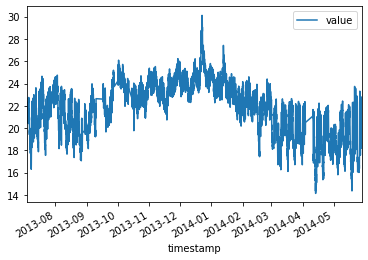

In [7]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

## 1.3 Feature engineering
먼저, 사용할 수 있는 변수를 추출합니다.
- hour: 시간 변수
- daylight: 하루 24시간을 day와 night로 구분하는 변수
    - day: 7:00 - 22:00
    - night: 23:00 - 06:00
    - DayOfWeek: 요일 변수
        - 월요일: 0
        - 일요일: 6
    - WeekDay: 주말 변수
        - 1: 평일
        - 0: 주말
    - time_epoch: 편한 시각화를 위해 생성한 변수
    - categories: 평일 & 주말|주간 & 야간 변수를 이용한 4개의 카테고리 변수
        - 주말 & 야간: 0
        - 주말 & 주간: 1
        - 평일 & 야간: 2
        - 평일 & 주간: 3
        
또한, 몇몇 알고리즘에서 필요한 데이터 내 이상 모집단의 추정값을 0.01로 두겠습니다. 추정값을 변경함으로써 어떤 변화가 발생하는지 잠시 후에 확인합니다.

In [8]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [10]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [11]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

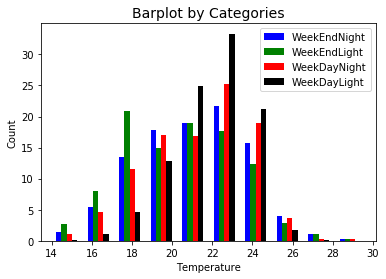

In [12]:
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.title('Barplot by Categories', fontsize = 14)
plt.xlabel('Temperature')
plt.ylabel('Count')

plt.legend()
plt.show()

주중 낮에는 온도가 비슷하다는 것을 알 수 있습니다.

# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered). 

먼저 k-Means Clustering을 일반적인 특성의 조합을 이용해 군집화를 수행합니다. 군집에서 멀리 떨어져있는 관측값은 이상값으로 간주할 것입니다. 수행 과정은 다음과 같습니다.

1. 사용 변수 표준화 수행
2. PCA를 이용한 차원 축소
3. 차원 축소한 요소 표준화 수행

In [13]:
# 사용 피쳐들에 대한 표준화 수행
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# Principal Component Analysis를 이용하여 5차원의 데이터를 2차원으로 축소
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

- Elbow Method: 군집의 수를 순차적으로 늘려가면서 결과를 모니터링합니다. 군집을 추가했을 때, 이전보다 '훨씬' 더 나은 결과를 나타내지 않는다면, 직전 군집 수로 결정합니다.
- WCSS: Within-Cluster-Sum-of-Squares: 군집 중심으로부터 관측값들의 거리 제곱합

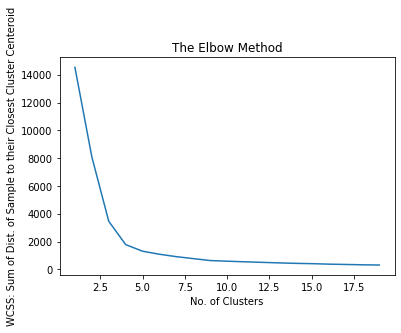

In [14]:
wcss = []
for i in range(1,20):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    # n_cluster: 군집의 수 결정
    # init: 알고리즘 결정. K-means: k-means++
    # max_iter: 단일 실행에 대한 k-means 알고리즘의 최대 반복 수
    # n_init: 초기 중심값 시도 횟수
    km.fit(data)
    wcss.append(km.inertia_)
    # inertia_: 샘플과 가장 가까운 군집 중심까지 거리 제곱합 (WCSS)
    
plt.plot(range(1,20), wcss)
plt.title('The Elbow Method', fontsize = 12)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of Dist. of Sample to their Closest Cluster Centeroid')

plt.show()

명확하진 않지만, 15개의 중심값(커널 기준)으로 분석을 진행하겠습니다. 군집 라벨을 데이터프레임에 추가합니다. 라벨별 관측값의 빈도수는 다음과 같습니다.

In [15]:
kmeans_result = KMeans(n_clusters = 15, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
kmeans_label = kmeans_result.fit_predict(data)
df['cluster'] = kmeans_label
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     712
5     649
9     627
8     617
14    599
11    579
7     576
4     537
10    397
1     358
13    354
3     347
2     340
6     337
12    238
Name: cluster, dtype: int64

이제, 군집화 결과를 시각화합니다

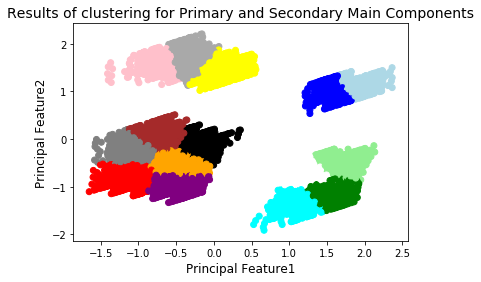

In [16]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))

plt.title("Results of clustering for Primary and Secondary Main Components", fontsize = 14)
plt.xlabel('Principal Feature1', fontsize = 12)
plt.ylabel('Principal Feature2', fontsize = 12)
plt.show()

In [17]:
# 각 관측값 벡터와 관측값이 속한 군집 중심점 벡터의 거리 계산. 거리가 클수록 Anomaly하다는 것으로 고려해야한다.
distance = getDistanceByPoint(data, kmeans_result) 
number_of_outliers = int(outliers_fraction*len(distance)) 
# 이상치의 개수 결정. outliers_fraction = 0.01이므로, 전체 관측값의 1%를 이상값으로 결정

In [18]:
threshold = distance.nlargest(number_of_outliers).min()
# 이상치로 분류된 값의 최소 거리를 임계치로 설정
df['anomaly21'] = (distance >= threshold).astype(int)
# 최소 임계치보다 큰 거리의 값들은 1 (Anomlay), 0 (nomaly)으로 라벨링

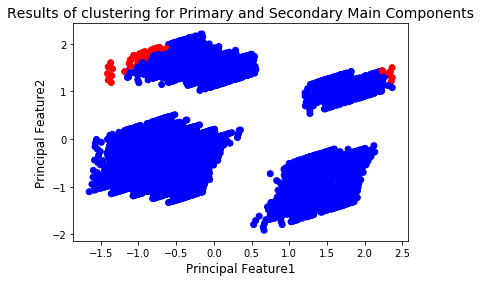

In [19]:
# 붉은 색은 Anomaly Values, 파란 색은 Nomaly Values로 시각화
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))

plt.title("Results of clustering for Primary and Secondary Main Components", fontsize = 14)
plt.xlabel('Principal Feature1', fontsize = 12)
plt.ylabel('Principal Feature2', fontsize = 12)
plt.show()

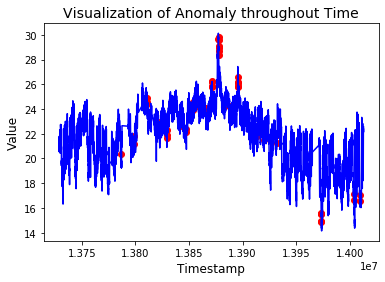

In [20]:
# 시간 경과에 따른 이상 징후 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.title("Visualization of Anomaly throughout Time", fontsize = 14)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

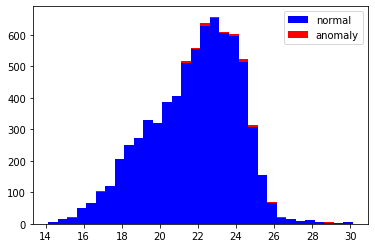

In [21]:
# 기온에 대한 히스토그램을 통해 이상 징후를 시각화
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster Method는 관측 기간 동안 고온을 비정상적으로 높은 온도로 감지합니다. 그러나 가장 낮은 온도는 잘 감지하지 못한다는 점을 알 수 있습니다.
## 2.2 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered). 
범주에 따라 데이터를 분할합니다. 다른 방법으로는 서로 다른 군집을 기반으로 데이터를 분할할 수 있습니다. 그 후, 각 범주를 이상치(Gaussian Distribution, Unimodal)를 독립적으로 탐색합니다. 

쉽게 말해, 정규 분포에서 벗어난 데이터를 이상치로 판단하는 방법입니다.

Scikit-Learn의 EllipticEnvelope는 Gaussian Distribution를 따르는 데이터에서 이상치를 탐지하기 위한 객체입니다. 

In [22]:
# 이전에 정의한 범주별로 데이터를 분할
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

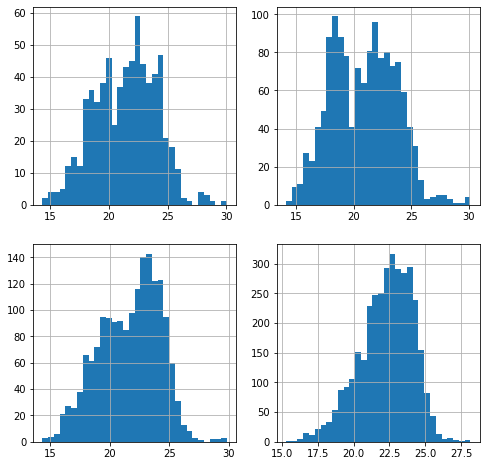

In [23]:
# 범주별 기온에 대한 분포 확인
fig, axs = plt.subplots(2,2, figsize= (8,8))
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

plt.show()

In [24]:
# 각 범주에 EllipticEnvelope(Gaussian Distribution)을 이용
# 정규 분포에서 벗어난 값을 이상치로 판단
def Outlier_Gaussian(df):
    global outliers_fraction
    
    envelope = EllipticEnvelope(contamination = outliers_fraction)
    X_train = df.values.reshape(-1,1)
    envelope.fit(X_train)
    df = pd.DataFrame(df)
    df['deviation'] = envelope.decision_function(X_train)
    df['anomaly'] = envelope.predict(X_train)
   
    return df

class0 = Outlier_Gaussian(df_class0)
class1 = Outlier_Gaussian(df_class1)
class2 = Outlier_Gaussian(df_class2)
class3 = Outlier_Gaussian(df_class3)

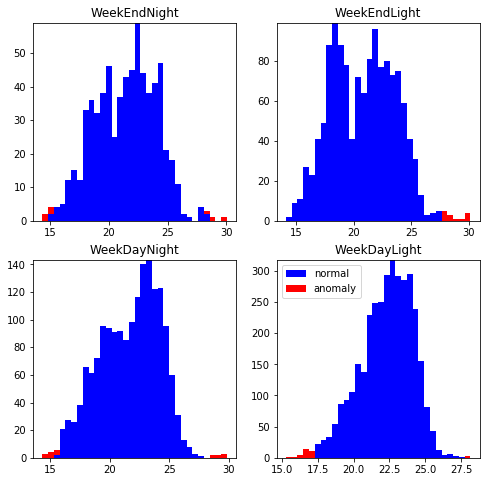

In [25]:
# 범주별 온도 분포에서 이상 징후가 존재하는 값들을 히스토그램으로 표시
a0 = class0.loc[class0['anomaly'] == 1, 'value'] # Normal
b0 = class0.loc[class0['anomaly'] == -1, 'value'] # Anomlay

a1 = class1.loc[class1['anomaly'] == 1, 'value'] # Normal
b1 = class1.loc[class1['anomaly'] == -1, 'value'] # Anomaly

a2 = class2.loc[class2['anomaly'] == 1, 'value'] # Normal
b2 = class2.loc[class2['anomaly'] == -1, 'value'] # Anomaly

a3 = class3.loc[class3['anomaly'] == 1, 'value'] # Normal
b3 = class3.loc[class3['anomaly'] == -1, 'value'] # Anomaly

fig, axs = plt.subplots(2,2, figsize = (8,8))

axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()

plt.show()

In [26]:
# 컬럼 추가
df_class = pd.concat([class0, class1, class2, class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

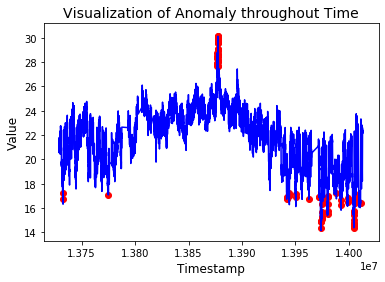

In [27]:
# 시간 경과에 따른 이상 징후 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.title("Visualization of Anomaly throughout Time", fontsize = 14)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

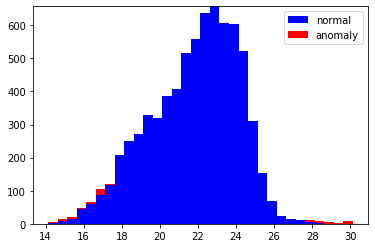

In [28]:
# 기온에 대한 히스토그램을 통해 이상 징후를 시각화
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

이전에 진행했던 Clustering Method보다 더 좋은 결과를 보입니다. 극단적인 값을 정확하게 감지하면 이상 감지의 정확도가 높아진다는 것을 알 수 있습니다. 
## 2.3 Cluster+Gaussian
2.2 방법과 유사하지만, 범주별로 데이터를 분할하는 것이 아닌, 군집별로 데이터를 분할하는 방법이 존재합니다.

In [29]:
cluster_list = [ [] for i in range(df['cluster'].nunique())]

for i,j in enumerate(cluster_list):
    j.append(df.loc[df['cluster'] == i, 'value'].tolist())

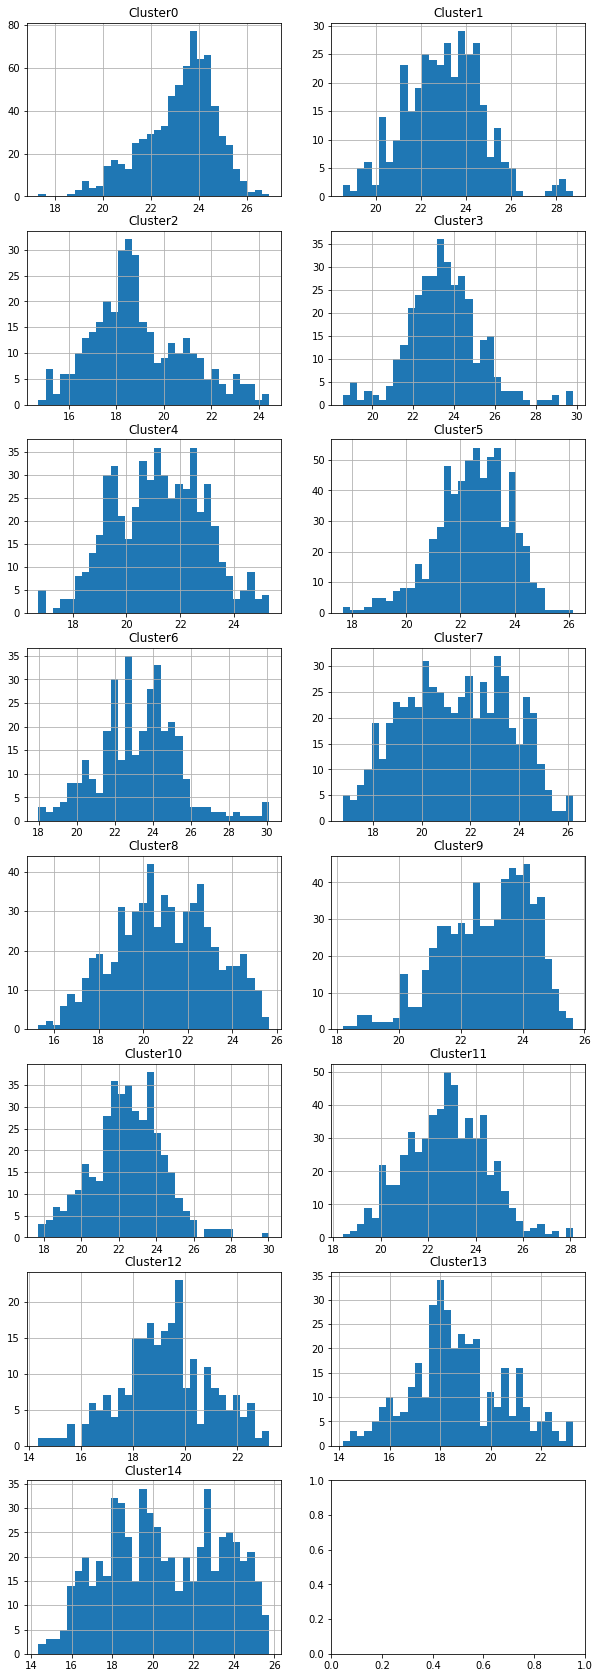

In [30]:
fig, axs = plt.subplots(8,2, figsize = (10,30))
subplots_list = list(itertools.product([0,1,2,3,4,5,6,7],[0,1]))

for i,j in zip(subplots_list,range(len(cluster_list))):
    pd.Series(cluster_list[j]).hist(ax = axs[i],bins = 32)
    
    axs[i].set_title("Cluster{}".format(j))
    
plt.show()

In [31]:
cluster_list = [e for sl in cluster_list for e in sl]
cluster_name = ["cluster{}".format(x) for x in np.sort(df['cluster'].unique())]

cluster_df = pd.DataFrame(cluster_list).transpose()
cluster_df.columns = cluster_name

In [32]:
def Outlier_Gaussian_Cluster(df):
    global outliers_fraction
    
    envelope = EllipticEnvelope(contamination = outliers_fraction)
    X_train = df.values.reshape(-1,1)
    envelope.fit(X_train)
    df = pd.DataFrame(df)
    df['deviation'] = envelope.decision_function(X_train)
    df['anomaly'] = envelope.predict(X_train)
    df.rename(columns = {df.columns[0]:'values'}, inplace = True)
    
    return df

def SegmentationAnomaly(x):
    a = x.loc[x['anomaly'] == 1, 'values']
    b = x.loc[x['anomaly'] == -1, 'values']
    
    return a, b

In [33]:
cluster0 = Outlier_Gaussian_Cluster(cluster_df['cluster0'].dropna())
cluster1 = Outlier_Gaussian_Cluster(cluster_df['cluster1'].dropna())
cluster2 = Outlier_Gaussian_Cluster(cluster_df['cluster2'].dropna())
cluster3 = Outlier_Gaussian_Cluster(cluster_df['cluster3'].dropna())
cluster4 = Outlier_Gaussian_Cluster(cluster_df['cluster4'].dropna())
cluster5 = Outlier_Gaussian_Cluster(cluster_df['cluster5'].dropna())
cluster6 = Outlier_Gaussian_Cluster(cluster_df['cluster6'].dropna())
cluster7 = Outlier_Gaussian_Cluster(cluster_df['cluster7'].dropna())
cluster8 = Outlier_Gaussian_Cluster(cluster_df['cluster8'].dropna())
cluster9 = Outlier_Gaussian_Cluster(cluster_df['cluster9'].dropna())
cluster10 = Outlier_Gaussian_Cluster(cluster_df['cluster10'].dropna())
cluster11 = Outlier_Gaussian_Cluster(cluster_df['cluster11'].dropna())
cluster12 = Outlier_Gaussian_Cluster(cluster_df['cluster12'].dropna())
cluster13 = Outlier_Gaussian_Cluster(cluster_df['cluster13'].dropna())
cluster14 = Outlier_Gaussian_Cluster(cluster_df['cluster14'].dropna())

In [34]:
a0, b0 = SegmentationAnomaly(cluster0)
a1, b1 = SegmentationAnomaly(cluster1)
a2, b2 = SegmentationAnomaly(cluster2)
a3, b3 = SegmentationAnomaly(cluster3)
a4, b4 = SegmentationAnomaly(cluster4)
a5, b5 = SegmentationAnomaly(cluster5)
a6, b6 = SegmentationAnomaly(cluster6)
a7, b7 = SegmentationAnomaly(cluster7)
a8, b8 = SegmentationAnomaly(cluster8)
a9, b9 = SegmentationAnomaly(cluster9)
a10, b10 = SegmentationAnomaly(cluster10)
a11, b11 = SegmentationAnomaly(cluster11)
a12, b12 = SegmentationAnomaly(cluster12)
a13, b13 = SegmentationAnomaly(cluster13)
a14, b14 = SegmentationAnomaly(cluster14)

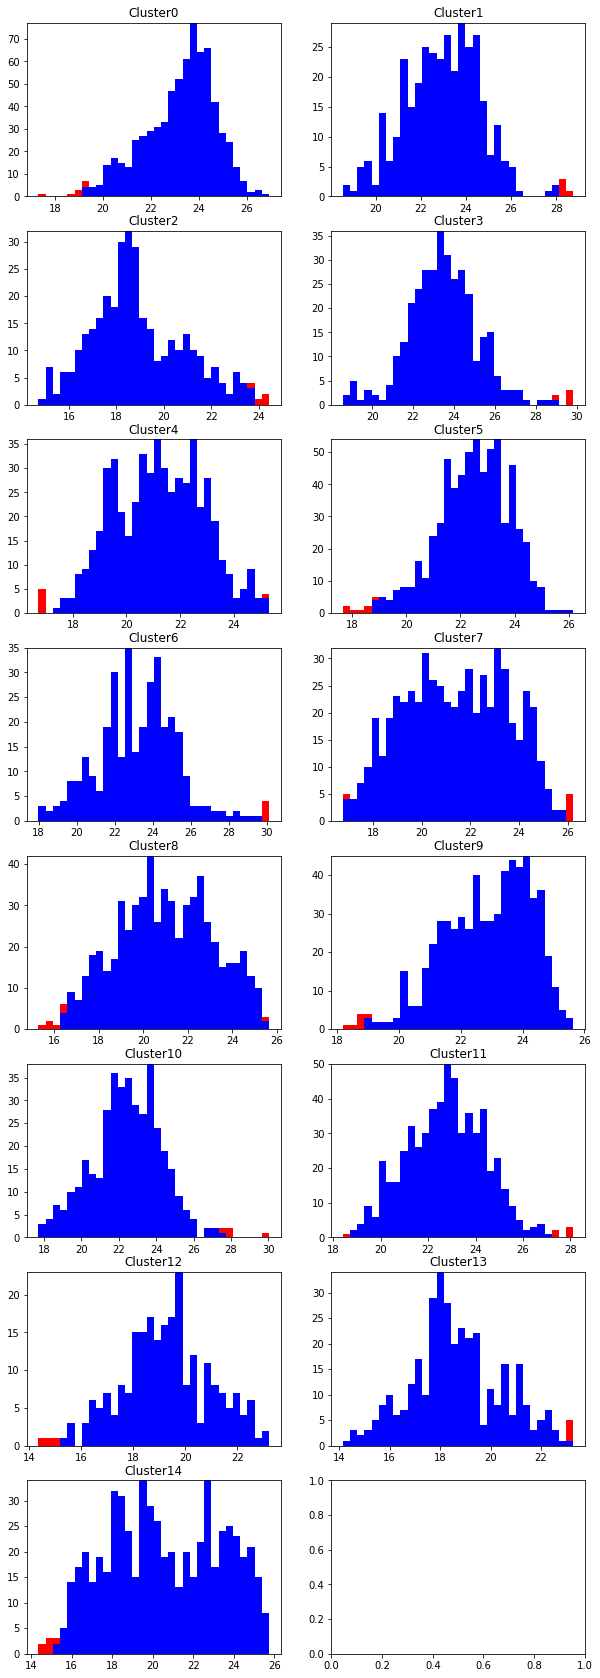

In [35]:
fig, axs = plt.subplots(8,2, figsize = (10, 30))

axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,0].hist([a4,b4], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,1].hist([a5,b5], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,0].hist([a6,b6], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,1].hist([a7,b7], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[4,0].hist([a8,b8], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[4,1].hist([a9,b9], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[5,0].hist([a10,b10], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[5,1].hist([a11,b11], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[6,0].hist([a12,b12], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[6,1].hist([a13,b13], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[7,0].hist([a14,b14], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

for i, j in zip(subplots_list, range(len(cluster_list))):
    axs[i].set_title('Cluster{}'.format(j))

plt.show()

In [36]:
# 컬럼 추가
df_cluster = pd.concat([cluster0, cluster1, cluster2, cluster3, cluster4, cluster5,
                       cluster6, cluster7, cluster8, cluster9, cluster10, cluster11,
                       cluster11, cluster12, cluster13, cluster14])
df_cluster.reset_index(drop = True, inplace = True)

df['anomaly23'] = df_cluster['anomaly']
df['anomaly23'] = np.array(df['anomaly23'] == -1).astype(int) 

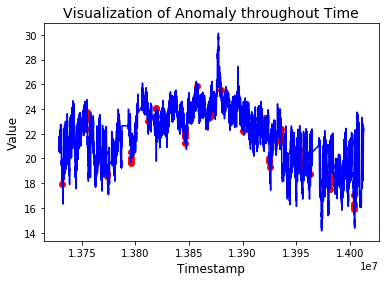

In [37]:
# 시간 경과에 따른 이상 징후 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly23'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.title("Visualization of Anomaly throughout Time", fontsize = 14)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Value', fontsize = 12)

plt.show()

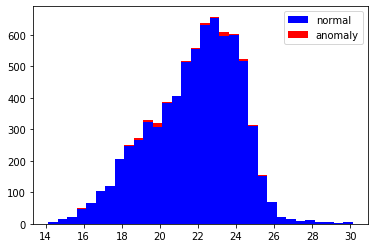

In [38]:
# 기온에 대한 히스토그램을 통해 이상 징후를 시각화
a = df.loc[df['anomaly23'] == 0, 'value']
b = df.loc[df['anomaly23'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Gaussian Method 보다 이상 감지 능력이 떨어진다는 것을 알 수 있습니다. 어느 정도 낮은 값에 대해서 이상 값이라 판단하지만, 아주 낮은 값과 높은 값에 대해서는 거의 감지를 하지 못합니다.

## 2.4 Markov chains
#### Use for  sequential anomalies (ordered)
Markov Chain을 이용한 이상 감지 방법을 설명하기 앞서 이론적 부분을 먼저 이해해야 합니다.

### Markov Chain(마르코프 연쇄)
Markov Chain이란 <b>확률 변수(Random Variable)가 어떤 상태(State)에 도달할 확률이 오직 바로 이전 시점의 상태(State)에 달려 있는 경우</b>를 가리킨다. 

예를 들어, 한 인터넷 사용자가 어떤 웹페이지에 있을 확률이 그 사람이 바로 직전에 어떤 웹페이지에 있었는가에 달려 있다면 인터넷 사용자의 웹페이지 방문은 마르코프 연쇄 모형을 따르고 있다고 말할 수 있다.

어떤 시점에서 한 청소년이 부모와 어떤 관계를 갖고 있는가가 그 바로 직전 시점에서 그 청소년이 부모와 어떤 관계를 갖고 있는가에 달려 있다면(더 이전에 그 청소년이 무보와 어떤 관계를 갖고있었는가는 무시해도 될 정도라면), 청소년과 부모와의 관계는 마르코프 연쇄모형을 따른다고 말할 수 있다.

Source: [윤영민의 필암글방: (Bayes 학습)(6)마르코프 연쇄(1)](http://piramvill2.org/wp/?p=905)

다른 예로, 강수 확률에 대한 모형을 Markov Chain으로 나타낸다고 생각해본다. 비가 온 상태를 0, 비가 오지 않은 상태를 1이라 하고 다음과 같은 행렬을 생성한다. 이러한 행렬은 전이 확률 행렬 (Transition Probability Matrix)

<img  src = "https://github.com/SSANGMAN/Anomaly_Detection/blob/master/image/Transition_Probability_Matrix.gif?raw=true">

이는 오늘 비가 왔다면 내일도 비가 올 확률이 70% 이고 비가 안 올 확률이 30%, 오늘 비가 왔다면 내일도 비가 안 올 확률이 60%이고 비가 올 확률이 40%라는 뜻이다.

전이 확률 행렬의 성질을 이용하여, k 시점 뒤의 전이 확률 행렬은 다음과 같이 나타낼 수 있다.

<img src = "https://github.com/SSANGMAN/Anomaly_Detection/blob/master/image/Transition_Probability_Matrix2.gif?raw=true">

만약 오늘 비가 왔다면 이틀 뒤의 강수 확률을 구하는 방식은 두 가지 방법이 존재한다. 

첫 번째는 전이 확률 행렬을 곱해주는 방법이다. 

<img src = 'https://github.com/SSANGMAN/Anomaly_Detection/blob/master/image/Two_Step_TPM.gif?raw=true'>

두 번째는 전이 확률 행렬의 유용한 성질을 이용해 구하는 방법이다.

<img src = 'https://github.com/SSANGMAN/Anomaly_Detection/blob/master/image/Two_Step_TPM2.gif?raw=true'>

Source: [생새우초밥집: 마코프 체인 MC Markov Chain](https://freshrimpsushi.tistory.com/859)

다시 예제로 돌아가, Markov Chain을 이용한 이상 감지 방법은 값을 이산화해야합니다. 5 가지 수준(매우 낮음, 낮음, 평균, 높음, 매우 높음) / (VL, L, A, H, VH)을 정의합니다. Markov Chain은 (VL, L, A, H, VH)와 같은 시퀀스 확률을 계산합니다. 확률이 매우 낮으면 해당 시퀀스를 이상으로 간주합니다.

이해의 어려움이 따르기 때문에 L, H 2 가지 수준으로 수행합니다. 

먼저, 함수를 정의하여 Transition Probability Matrix를 생성합니다.

In [198]:
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, lag = 1) # 시퀀스 데이터에 lag 1을 취하여 모델 생성 
	return model.transition_matrix # Markov Chain 전이 확률 행렬 생성

In [356]:
tm = getTransitionMatrix(df_mm)
tm

array([[0.92102016, 0.07897984],
       [0.03971044, 0.96028956]])

현재 시점의 온도가 낮다면 다음 시점도 낮을 확률이 92%이고 높을 확률은 7%, 현재 시점의 온도가 높다면 다음 시점도 높을 확률이 96%이고 낮을 확률이 3%임을 알 수 있습니다.

이제, 직전 시점 상태에 따른 현재 시점 상태의 확률 값을 반환하는 함수를 정의합니다.

In [316]:
def successProbabilityMetric(state1, state2, transitionmatrix): 
    # state1: 직전 시점 상태
    # state2: 현재 시점 상태
    proba = 0 
    
    for k in range(0,len(transitionmatrix)):
        if (k != (state2-1)):
            proba += transitionmatrix[state1-1][k]
        
        else:
            proba += transitionmatrix[state1-1][k+1]
        
        return 1-proba

In [317]:
print("Low Temperature -> Low Temperature Probability:",successProbabilityMetric(1,1, tm))
print("Low Temperature -> High Temperature Probability:",successProbabilityMetric(1,2, tm))
print("High Temperature -> Low Temperature Probability:",successProbabilityMetric(2,1, tm))
print("High Temperature -> High Temperature Probability:",successProbabilityMetric(2,2, tm))

Low Temperature -> Low Temperature Probability: 0.9210201563142739
Low Temperature -> High Temperature Probability: 0.07897984368572608
High Temperature -> Low Temperature Probability: 0.03971044467425022
High Temperature -> High Temperature Probability: 0.9602895553257498


이제, 전이 확률의 성질을 이용해 이후 시점 상태의 확률을 구하는 함수를 정의합니다. 

In [310]:
def sucessScore(sequence, transitionmatrix): 
    proba = 0 
    
    for i in range(1,len(sequence)):
        if(i == 1):  # 첫 번째 수행은 현재 시점의 상태에 따른 직후 시점의 상태에 대한 확률 할당
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transitionmatrix)
        else: # 이후 시점의 상태는 직후 시점 상태에 따라 확률값을 곱하여 계산
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transitionmatrix)

    return proba

다음은, 시점별 상태의 확률과 정의한 임계치를 비교하여 확률이 임계치 보다 크다면 0, 작거나 같으면 1로 반환합니다.

In [271]:
def anomalyElement(sequence, threshold, transitionmatrix): 
    if (sucessScore(sequence, transitionmatrix) > threshold):
        return 0
    else:
        return 1

In [363]:
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [377]:
""" 상태 정의
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5
"""
x1 = (df['value'] <= 21).astype(int) # 온도가 21도 이하인 시점은 1, 그렇지 않으면 0
x2 = (df['value'] > 21).astype(int) # 온도가 21도를 초과하는 시점은 1, 그렇지 않으면 0
df_mm = x1 + 2*x2 # 온도가 21도를 초과한다면 2를 곱한 후 (각각의 라벨을 구분하기 위해서) 리스트를 더해준다.

# 데이터 셋의 이상 징후 라벨을 생성합니다.
# window size = 5
# threshold = 0.2
## TO-DO: (Threshold 가 무엇을 의미하는지 잘 모르겠다.)
df_anomaly = markovAnomaly(df_mm, 5, 0.2)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    7134
1     133
dtype: int64


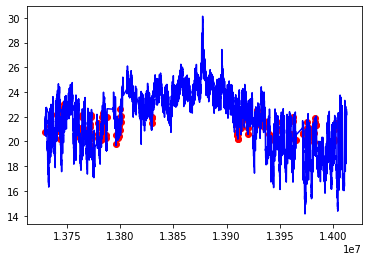

In [378]:
# 컬럼 추가
df['anomaly24'] = df_anomaly

# 시간 경과에 따른 이상 징후 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No handles with labels found to put in legend.


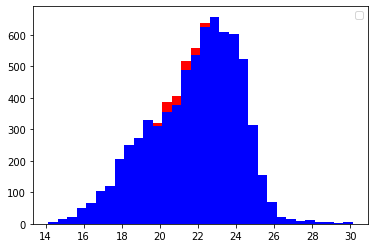

In [379]:
# 기온에 대한 히스토그램을 통해 이상 징후를 시각화
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])

plt.legend()
plt.show()

비정상적인 시퀀스를 감지하지만, 극단적인 값들을 감지하지 못한다는 단점이 존재합니다. 또한 시퀀스의 크기(Window Size)를 데이터의 패턴과 일치해야한다는 단점이 존재합니다. 

## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Regression Tree 기반의 분할 방법으로 모든 데이터 관측값을 고립시키는 방법입니다. 특징은 다음과 같습니다.
- 비정상 데이터가 고립: Root Node와 가까운 Depth를 가짐
- 정상 데이터가 고립: Leaf Node와 가까운 Depth를 가짐

<img src = "https://ko.logpresso.com/api/documents/23/sections/122/images/image2.png" width = 600 >

Source: [LOGPRESSO: 의사결정나무를 이용한 이상탐지](https://ko.logpresso.com/documents/anomaly-detection)

- 특정 데이터가 고립되는 Leaf Node까지의 거리를 Outlier Score로 정의
- Depth가 짧을 수록 Outlier Score가 높아짐

<img src = "https://i.imgur.com/rzP7siS.png" width = 600>

Source: [donghwa-kim.github.io: Isolation Forest](https://donghwa-kim.github.io/iforest.html)

In [380]:
# 사용할 변수 선택과 표준화 수행
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# 모델 훈련
model =  IsolationForest(contamination = outliers_fraction) # 전체의 1%를 Anomaly로 선택
model.fit(data)

# 컬럼 추가
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


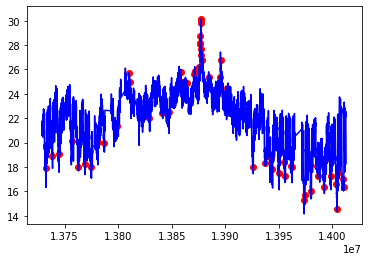

In [381]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

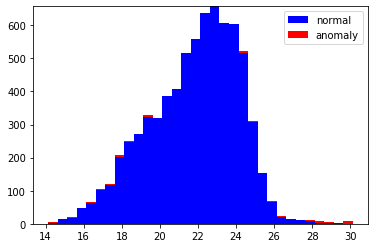

In [370]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.6 One class SVM
#### Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [ ]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.
## 2.7 RNN
#### Use for  sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.  
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [ ]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

In [ ]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [ ]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

In [ ]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)


In [ ]:
# save the model because the training is long (1h30) and we don't want to do it every time
"""
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
"""

In [ ]:
# load json and create model
"""
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
"""

In [ ]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [ ]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## 2.8 Collective and sequential anomalies (Ordered)
This class is most general and consider ordering as well as value combinations. We usually use combination of algorithm like cluster+markov model.
## 3 Result comparison
(may be later)
## 4 Conclusion
For this case, the contextual anomaly detection (categories+elliptique enveloppe) seem a good solution. 